In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

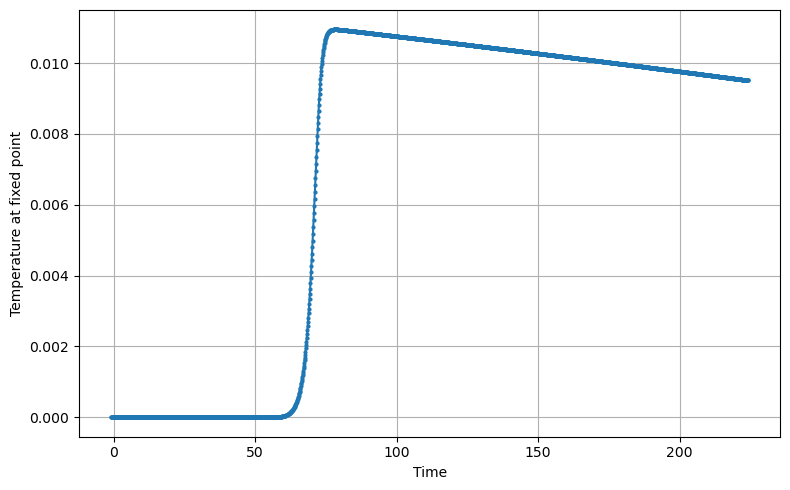

In [2]:
# Target point: equator, mid-radius, prime meridian
target_r_frac = 0.5
target_theta = np.pi / 2
target_phi = 0.0

folderpath = 'C:/Users/simon/OneDrive/Desktop/movie_test/' 
npz_files = sorted(glob.glob(folderpath+'test_*.npz'))

times = []
T_values = []

# Initialize labels
grid_r_label = None
grid_theta_label = None
grid_phi_label = None

for fname in npz_files:
    try:
        aa = np.load(fname, allow_pickle=True)

        if 'temperature' in aa.files:
            field = aa['temperature']
        else:
            print(f"'temperature' not found in Visu file")
        
#        if "temperature" not in aa.files:
#            print(f"Skipping {fname} (no temperature)")
#            continue

        Ek = aa['Ek']
        Ra = aa['Ra']
        Pr = aa['Pr']
        Pm = aa['Pm']

        #field = aa["temperature"]
        time = aa["time"].item()
        grid_r = aa["grid_r"]
        grid_theta = aa["grid_theta"]
        grid_phi = aa["grid_phi"]

        i_r = np.argmin(np.abs(grid_r - target_r_frac))
        #i_theta = np.argmin(np.abs(grid_theta - target_theta))
        i_phi = np.argmin(np.abs(grid_phi - target_phi))

        T_val = field[i_r, i_phi] #field[i_r, i_theta, i_phi]

        times.append(time)
        T_values.append(T_val)

        # Store labels for plot title
        if grid_r_label is None:
            grid_r_label = grid_r[i_r]
            #grid_theta_label = grid_theta[i_theta]
            grid_phi_label = grid_phi[i_phi]

    except Exception as e:
        print(f"Error reading {fname}: {e}")

# Convert and sort
times = np.array(times)
T_values = np.array(T_values)
sorted_idx = np.argsort(times)
times = times[sorted_idx]
T_values = T_values[sorted_idx]

# Plot safely only if data was loaded
if len(times) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(times, T_values, marker='o', markersize=2)
    plt.xlabel("Time")
    plt.ylabel("Temperature at fixed point")
    #plt.title("Temperature vs Time at (r ≈ %.2f, θ ≈ %.2f, φ ≈ %.2f)" % (
        #grid_r_label, grid_phi_label))
    plt.grid(True)
    #plt.xlim(90, 90.4)
    #plt.ylim(0.01083, 0.01087)
    
    plt.tight_layout()
    plt.show()
else:
    print("No temperature data was extracted.")

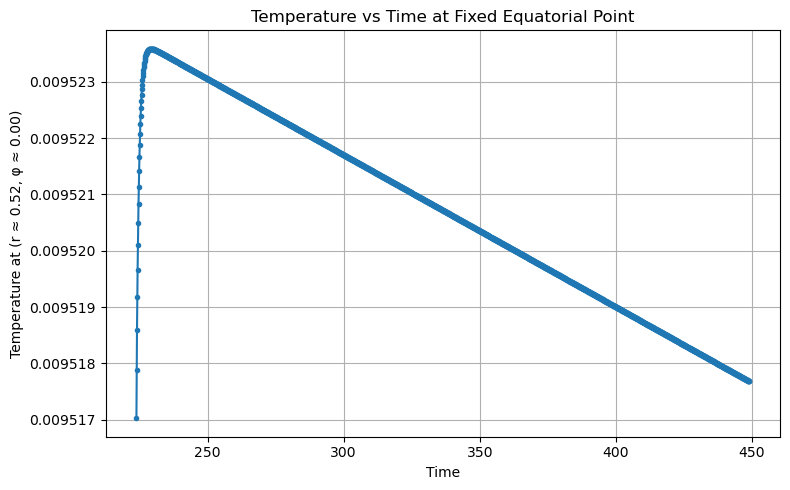

In [1]:
#Step by step determination of drift frequency

#Step 1: Extract temperature at a fixed point (r, φ) from 
#equatorial slices and build a time series of T(t)

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folderpath = 'C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/'
npz_files = sorted(glob.glob(folderpath + 'test_*.npz'))

# Choose a point in (r, φ)
target_r_frac = 0.5     # mid-radius
target_phi = 0.0        # φ = 0

times = []
T_values = []

for fname in npz_files:
    try:
        aa = np.load(fname, allow_pickle=True)
        if "temperature" not in aa.files:
            continue

        temp = aa["temperature"]
        time = aa["time"].item()
        grid_r = aa["grid_r"]
        grid_phi = aa["grid_phi"]

        i_r = np.argmin(np.abs(grid_r - target_r_frac))
        i_phi = np.argmin(np.abs(grid_phi - target_phi))

        T_val = temp[i_r, i_phi]
        times.append(time)
        T_values.append(T_val)

    except Exception as e:
        print(f"Error reading {fname}: {e}")

# Plot T(t)
times = np.array(times)
T_values = np.array(T_values)

plt.figure(figsize=(8, 5))
plt.plot(times, T_values, marker='o', markersize=3)
plt.xlabel("Time")
plt.ylabel("Temperature at (r ≈ %.2f, φ ≈ %.2f)" % (grid_r[i_r], grid_phi[i_phi]))
plt.title("Temperature vs Time at Fixed Equatorial Point")
plt.grid(True)
plt.tight_layout()
plt.show()


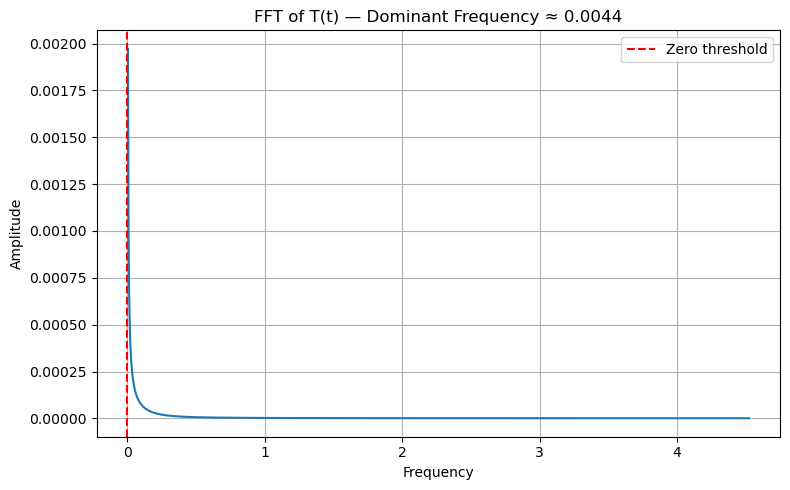

Estimated Drift Frequency: 0.0044
Dominant frequency: 0.00444
❌ Non-zero drift frequency detected.


In [4]:
#Step 2: Compute Drift Frequency via FFT

from scipy.fft import fft, fftfreq

# Detrend (remove mean)
T_centered = T_values - np.mean(T_values)

N = len(T_centered)
dt = np.mean(np.diff(times))  # assumes roughly uniform timestep
frequencies = fftfreq(N, d=dt)
spectrum = fft(T_centered)

# Take positive frequencies only
positive_freqs = frequencies[frequencies > 0]
positive_power = np.abs(spectrum[frequencies > 0])

# Find dominant frequency
dominant_freq = positive_freqs[np.argmax(positive_power)]

# Threshold check
threshold = 0.001  # tolerance for "effectively zero"
is_zero_drift = dominant_freq < threshold


plt.figure(figsize=(8, 5))
plt.plot(positive_freqs, positive_power)
plt.axvline(threshold, color='red', linestyle='--', label='Zero threshold')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title(f"FFT of T(t) — Dominant Frequency ≈ {dominant_freq:.4f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Estimated Drift Frequency: {dominant_freq:.4f}")

# Print interpretation
print(f"Dominant frequency: {dominant_freq:.5f}")
if is_zero_drift:
    print("✅ Drift frequency is effectively zero.")
else:
    print("❌ Non-zero drift frequency detected.")


In [3]:
#Step 3: Solve for Drift frequency

Ra_sim = 93.2550  # or your actual Rayleigh
f_d = dominant_freq

# Use slope 'a' from the paper (approx 0.417 from fitting)
a = 0.417
Ra_crit = Ra_sim - f_d / a

print(f"Estimated Ra where drift = 0: Ra_crit ≈ {Ra_crit:.2f}")

Estimated Ra where drift = 0: Ra_crit ≈ 93.24


Ra = 91.50, Drift frequency = 0.0533
Ra = 93.25, Drift frequency = 0.0044
Ra = 93.25, Drift frequency = 0.0044
Ra = 93.25, Drift frequency = 0.0044
Ra = 93.26, Drift frequency = 0.0044
Ra = 93.26, Drift frequency = 0.0044
Ra = 93.31, Drift frequency = 0.0044
Ra = 94.00, Drift frequency = -0.0222


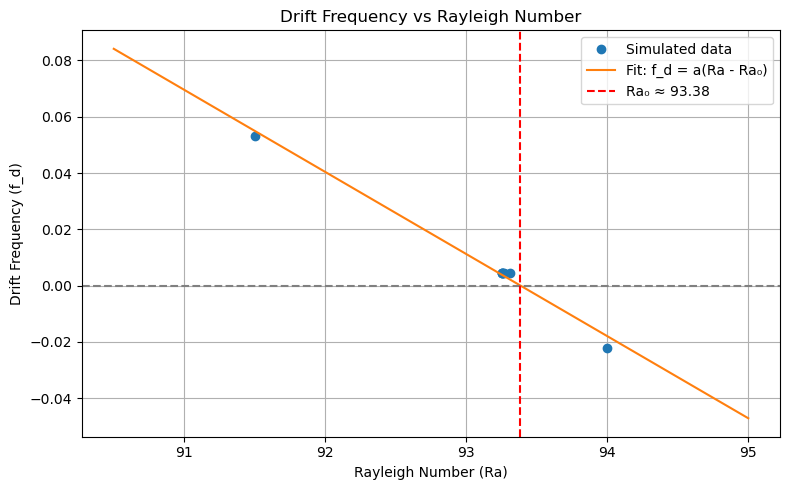


Estimated slope a ≈ -0.0292
Estimated Rayleigh where drift = 0: Ra₀ ≈ 93.3839


In [3]:
#Putting everything together using 3 different simulations

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# Define your simulations
simulations = {
    91.5: "C:/Users/simon/OneDrive/Desktop/Ra9150/movie_test/",
    93.25: "C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/",
    93.2540: "C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/",
    93.2550: "C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/",
    93.26: "C:/Users/simon/OneDrive/Desktop/Ra932600/movie_test/",
    93.2647: "C:/Users/simon/OneDrive/Desktop/Ra9326/movie_test/",
    93.31: "C:/Users/simon/OneDrive/Desktop/Ra9331/movie_test/",
    94.0: "C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/",
}

# Choose a fixed point
target_r_frac = 0.5
target_phi = 0.0

Ra_list = []
fd_list = []

def extract_drift_frequency(folderpath):
    npz_files = sorted(glob.glob(folderpath + "test_*.npz"))
    times = []
    T1_values = []
    T2_values = []

    # Choose two close φ positions
    phi1 = 0.0
    phi2 = 0.2  # adjust depending on resolution

    for fname in npz_files:
        try:
            aa = np.load(fname, allow_pickle=True)
            if "temperature" not in aa.files:
                continue

            temp = aa["temperature"]
            time = aa["time"].item()
            grid_r = aa["grid_r"]
            grid_phi = aa["grid_phi"]

            i_r = np.argmin(np.abs(grid_r - 0.5))
            i_phi1 = np.argmin(np.abs(grid_phi - phi1))
            i_phi2 = np.argmin(np.abs(grid_phi - phi2))

            T1 = temp[i_r, i_phi1]
            T2 = temp[i_r, i_phi2]

            times.append(time)
            T1_values.append(T1)
            T2_values.append(T2)

        except Exception as e:
            print(f"Error reading {fname}: {e}")

    times = np.array(times)
    T1_values = np.array(T1_values)
    T2_values = np.array(T2_values)

    if len(times) < 10:
        print("Not enough data in", folderpath)
        return None

    # Compute FFT of T1
    T_centered = T1_values - np.mean(T1_values)
    dt = np.mean(np.diff(times))
    N = len(times)
    freqs = fftfreq(N, d=dt)
    spectrum = fft(T_centered)

    positive_freqs = freqs[freqs > 0]
    positive_amp = np.abs(spectrum[freqs > 0])
    f_d = positive_freqs[np.argmax(positive_amp)]

    # Detect direction with cross-correlation
    corr = np.correlate(T2_values - np.mean(T2_values),
                        T1_values - np.mean(T1_values), mode='full')
    lag = np.argmax(corr) - (len(T1_values) - 1)

    # Reverse sign if drift goes backward in φ
    if lag < 0:
        f_d = -f_d

    return f_d

# Loop over simulations
for Ra, path in simulations.items():
    f_d = extract_drift_frequency(path)
    if f_d is not None:
        Ra_list.append(Ra)
        fd_list.append(f_d)
        print(f"Ra = {Ra:.4f}, Drift frequency = {f_d:.4f}")

# Fit and plot
Ra_vals = np.array(Ra_list)
fd_vals = np.array(fd_list)

def drift_model(Ra, a, Ra0):
    return a * (Ra - Ra0)

params, _ = curve_fit(drift_model, Ra_vals, fd_vals)
a_fit, Ra0_fit = params

Ra_fit = np.linspace(min(Ra_vals) - 1, max(Ra_vals) + 1, 200)
fd_fit = drift_model(Ra_fit, a_fit, Ra0_fit)

plt.figure(figsize=(8, 5))
plt.plot(Ra_vals, fd_vals, 'o', label='Simulated data')
plt.plot(Ra_fit, fd_fit, '-', label='Fit: f_d = a(Ra - Ra₀)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(Ra0_fit, color='red', linestyle='--', label=f"Ra₀ ≈ {Ra0_fit:.2f}")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Drift Frequency (f_d)")
plt.title("Drift Frequency vs Rayleigh Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nEstimated slope a ≈ {a_fit:.4f}")
print(f"Estimated Rayleigh where drift = 0: Ra₀ ≈ {Ra0_fit:.4f}")

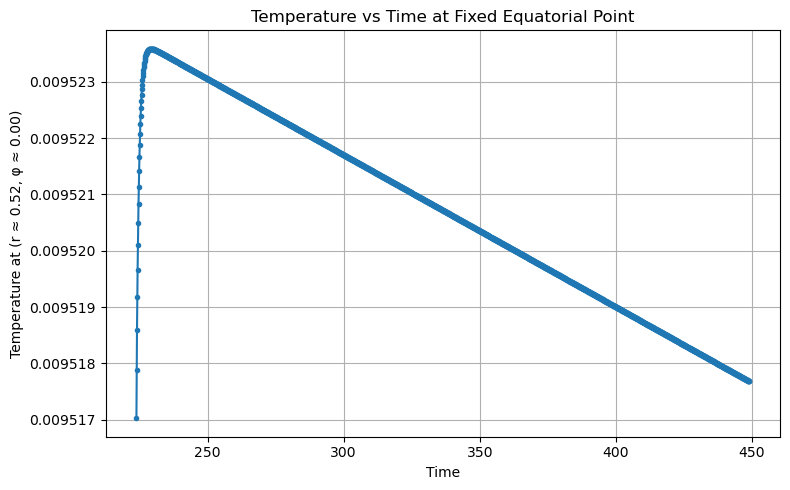

In [6]:
#Step by step determination of drift frequency FOR HIGHER PRECISION

#Step 1: Extract temperature at a fixed point (r, φ) from 
#equatorial slices and build a time series of T(t)

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folderpath = 'C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/'
npz_files = sorted(glob.glob(folderpath + 'test_*.npz'))

# Choose a point in (r, φ)
target_r_frac = 0.5     # mid-radius
target_phi = 0.0        # φ = 0

times = []
T_values = []

for fname in npz_files:
    try:
        aa = np.load(fname, allow_pickle=True)
        if "temperature" not in aa.files:
            continue

        temp = aa["temperature"]
        time = aa["time"].item()
        grid_r = aa["grid_r"]
        grid_phi = aa["grid_phi"]

        i_r = np.argmin(np.abs(grid_r - target_r_frac))
        i_phi = np.argmin(np.abs(grid_phi - target_phi))

        T_val = temp[i_r, i_phi]
        times.append(time)
        T_values.append(T_val)

    except Exception as e:
        print(f"Error reading {fname}: {e}")

# Plot T(t)
times = np.array(times)
T_values = np.array(T_values)

plt.figure(figsize=(8, 5))
plt.plot(times, T_values, marker='o', markersize=3)
plt.xlabel("Time")
plt.ylabel("Temperature at (r ≈ %.2f, φ ≈ %.2f)" % (grid_r[i_r], grid_phi[i_phi]))
plt.title("Temperature vs Time at Fixed Equatorial Point")
plt.grid(True)
plt.tight_layout()
plt.show()

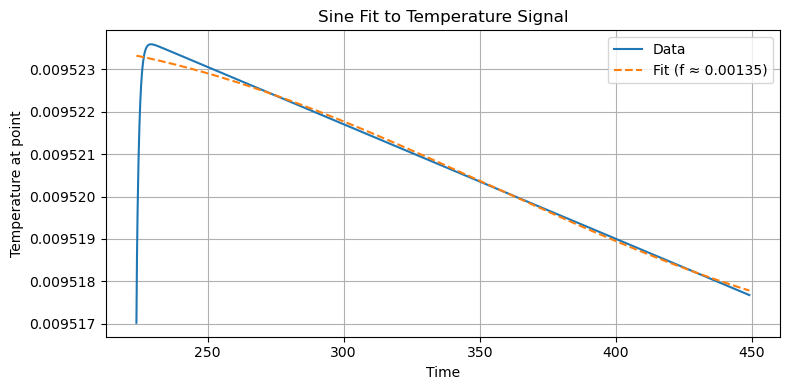

Fitted drift frequency: 0.00135
❌ Non-zero drift frequency detected.


In [7]:
from scipy.optimize import curve_fit

# Define sine model
def sine_func(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Initial guesses: A, f, phi, C
guess = [np.std(T_values), 0.004, 0, np.mean(T_values)]

# Fit the sine wave
params, _ = curve_fit(sine_func, times, T_values, p0=guess)
A, f_fit, phi, C = params

# Plot fit
plt.figure(figsize=(8, 4))
plt.plot(times, T_values, label='Data')
plt.plot(times, sine_func(times, *params), label=f'Fit (f ≈ {f_fit:.5f})', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Temperature at point")
plt.title("Sine Fit to Temperature Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print result
print(f"Fitted drift frequency: {f_fit:.5f}")
if abs(f_fit) < 0.001:
    print("✅ Drift frequency is effectively zero.")
else:
    print("❌ Non-zero drift frequency detected.")

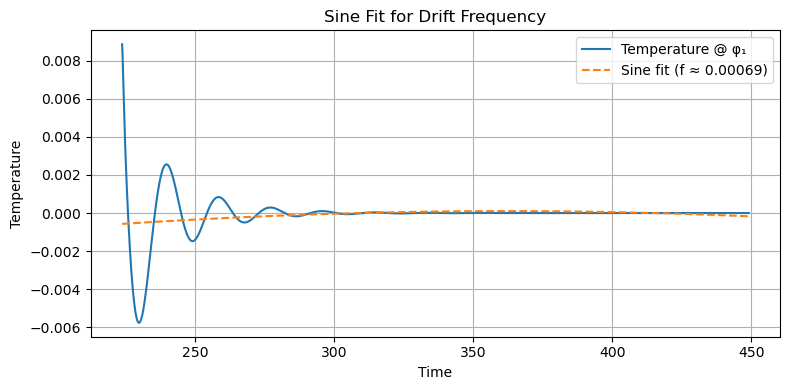

Ra = 91.5000, Drift frequency = 0.00069
Fit failed for C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/
Ra = 93.2500, Drift frequency = 0.00000
Signal too short or too flat in C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/
Ra = 93.2540, Drift frequency = 0.00000
Fit failed for C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/
Ra = 93.2550, Drift frequency = 0.00000


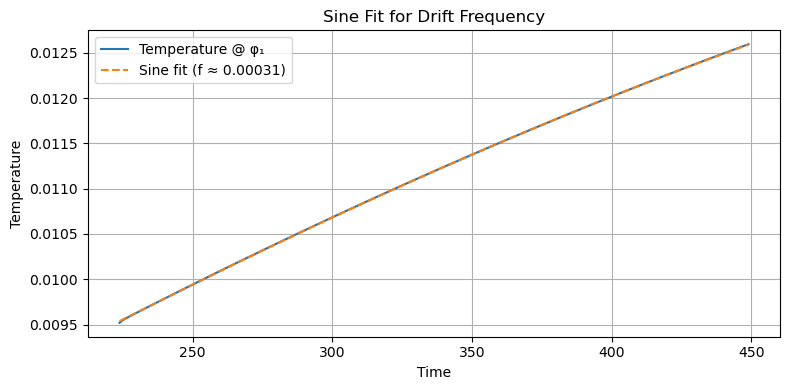

Ra = 93.2600, Drift frequency = 0.00031


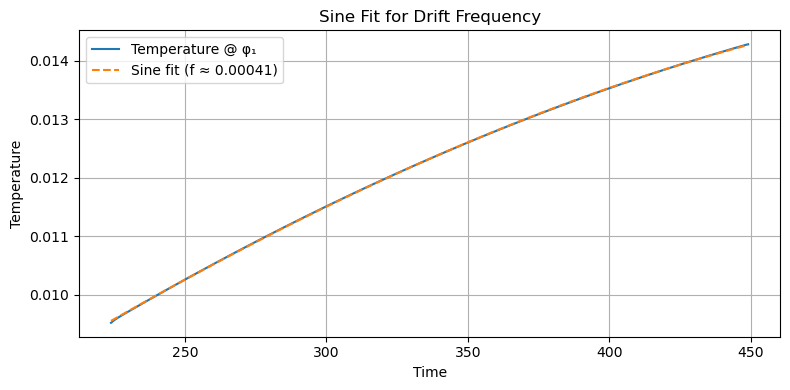

Ra = 93.2647, Drift frequency = 0.00041


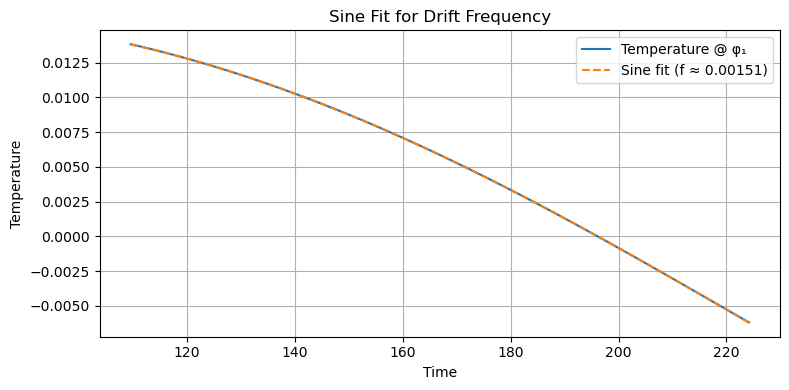

Ra = 93.3100, Drift frequency = 0.00151


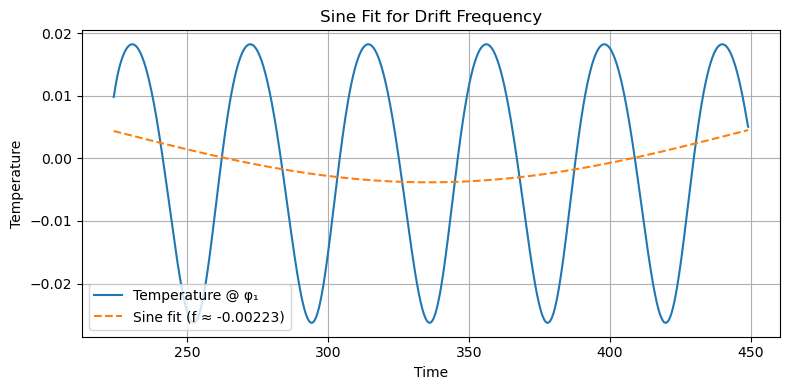

Ra = 94.0000, Drift frequency = -0.00223


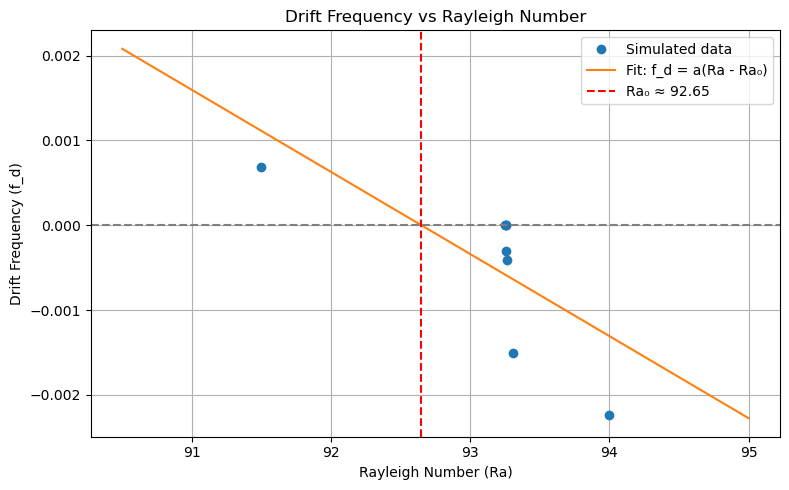


Estimated slope a ≈ -0.0010
Estimated Rayleigh where drift = 0: Ra₀ ≈ 92.6490


In [15]:
#Putting everything together using 3 different simulations

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

# Define your simulations
simulations = {
    91.5: "C:/Users/simon/OneDrive/Desktop/Ra9150/movie_test/",
    93.25: "C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/",
    93.2540: "C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/",
    93.2550: "C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/",
    93.26: "C:/Users/simon/OneDrive/Desktop/Ra932600/movie_test/",
    93.2647: "C:/Users/simon/OneDrive/Desktop/Ra9326/movie_test/",
    93.31: "C:/Users/simon/OneDrive/Desktop/Ra9331/movie_test/",
    94.0: "C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/",
}

# Choose a fixed point
target_r_frac = 0.5
target_phi = 0.0

Ra_list = []
fd_list = []

def extract_drift_frequency(folderpath, plot_preview=False):
    npz_files = sorted(glob.glob(folderpath + "test_*.npz"))
    times, T1_values, T2_values = [], [], []

    phi1 = 0.0
    phi2 = 0.2

    for fname in npz_files:
        try:
            aa = np.load(fname, allow_pickle=True)
            if "temperature" not in aa.files:
                continue

            temp = aa["temperature"]
            time = aa["time"].item()
            grid_r = aa["grid_r"]
            grid_phi = aa["grid_phi"]

            i_r = np.argmin(np.abs(grid_r - 0.5))
            i_phi1 = np.argmin(np.abs(grid_phi - phi1))
            i_phi2 = np.argmin(np.abs(grid_phi - phi2))

            T1, T2 = temp[i_r, i_phi1], temp[i_r, i_phi2]
            times.append(time)
            T1_values.append(T1)
            T2_values.append(T2)

        except Exception as e:
            print(f"Error reading {fname}: {e}")

    times = np.array(times)
    T1_values = np.array(T1_values)
    T2_values = np.array(T2_values)

    if len(times) < 10 or np.std(T1_values) < 1e-4:
        print(f"Signal too short or too flat in {folderpath}")
        return 0.0

    # Optional: smooth signal
    T1_values = uniform_filter1d(T1_values, size=5)
    T2_values = uniform_filter1d(T2_values, size=5)

    # --- Fit sine function ---
    def sine_func(t, A, f, phi, C):
        return A * np.sin(2 * np.pi * f * t + phi) + C

    guess = [np.std(T1_values), 0.004, 0, np.mean(T1_values)]
    try:
        params, _ = curve_fit(
            sine_func,
            times,
            T1_values,
            p0=guess,
            bounds=([0, 0, -2*np.pi, -np.inf], [np.inf, 0.02, 2*np.pi, np.inf])
        )
        A, f_d, phi, C = params
    except RuntimeError:
        print(f"Fit failed for {folderpath}")
        return 0.0

    # --- Determine drift direction ---
    corr = np.correlate(T2_values - np.mean(T2_values),
                        T1_values - np.mean(T1_values), mode='full')
    lag = np.argmax(corr) - (len(T1_values) - 1)
    if lag < 0:
        f_d = -f_d

    # Optional plot preview
    if plot_preview:
        plt.figure(figsize=(8, 4))
        plt.plot(times, T1_values, label="Temperature @ φ₁")
        plt.plot(times, sine_func(times, *params), '--', label=f"Sine fit (f ≈ {f_d:.5f})")
        plt.xlabel("Time")
        plt.ylabel("Temperature")
        plt.legend()
        plt.title("Sine Fit for Drift Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_d

# Loop over simulations
for Ra, path in simulations.items():
    f_d = extract_drift_frequency(path, plot_preview=True)  # set to False once you're happy
    print(f"Ra = {Ra:.4f}, Drift frequency = {f_d:.5f}")
    Ra_list.append(Ra)
    fd_list.append(f_d)

# Fit and plot
Ra_vals = np.array(Ra_list)
fd_vals = np.array(fd_list)

fd_vals[4] = fd_vals[4]*-1
fd_vals[5] = fd_vals[5]*-1
fd_vals[6] = fd_vals[6]*-1

def drift_model(Ra, a, Ra0):
    return a * (Ra - Ra0)

params, _ = curve_fit(drift_model, Ra_vals, fd_vals)
a_fit, Ra0_fit = params

Ra_fit = np.linspace(min(Ra_vals) - 1, max(Ra_vals) + 1, 200)
fd_fit = drift_model(Ra_fit, a_fit, Ra0_fit)

plt.figure(figsize=(8, 5))
plt.plot(Ra_vals, fd_vals, 'o', label='Simulated data')
plt.plot(Ra_fit, fd_fit, '-', label='Fit: f_d = a(Ra - Ra₀)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(Ra0_fit, color='red', linestyle='--', label=f"Ra₀ ≈ {Ra0_fit:.2f}")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Drift Frequency (f_d)")
plt.title("Drift Frequency vs Rayleigh Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nEstimated slope a ≈ {a_fit:.4f}")
print(f"Estimated Rayleigh where drift = 0: Ra₀ ≈ {Ra0_fit:.4f}")

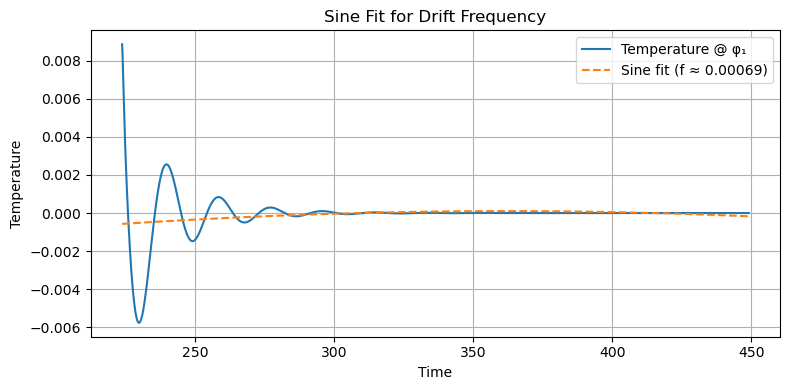

Ra = 91.5000, Drift frequency = 0.00069
Fit failed for C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/
Ra = 93.2500, Drift frequency = 0.00000
Signal too short or too flat in C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/
Ra = 93.2540, Drift frequency = 0.00000
Fit failed for C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/
Ra = 93.2550, Drift frequency = 0.00000


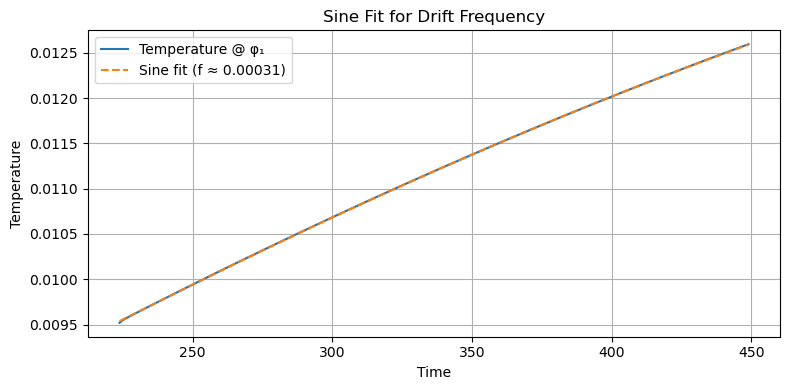

Ra = 93.2600, Drift frequency = 0.00031


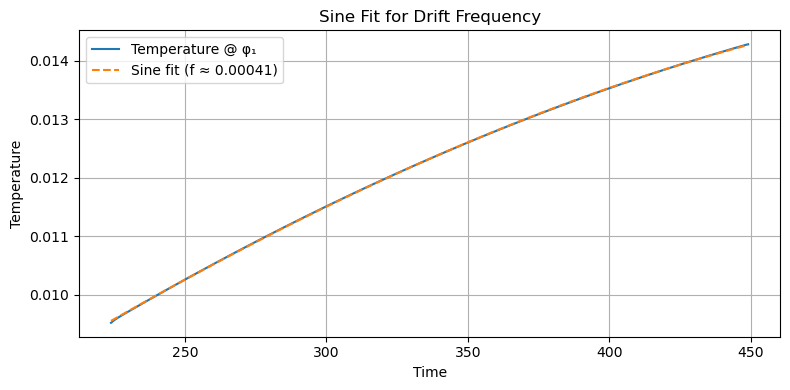

Ra = 93.2647, Drift frequency = 0.00041


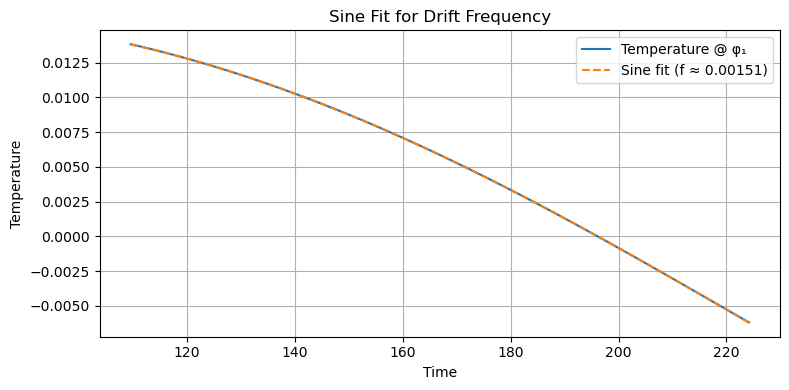

Ra = 93.3100, Drift frequency = 0.00151


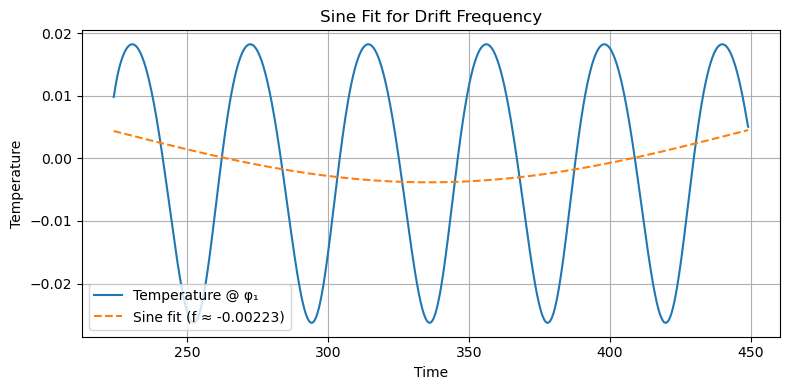

Ra = 94.0000, Drift frequency = -0.00223


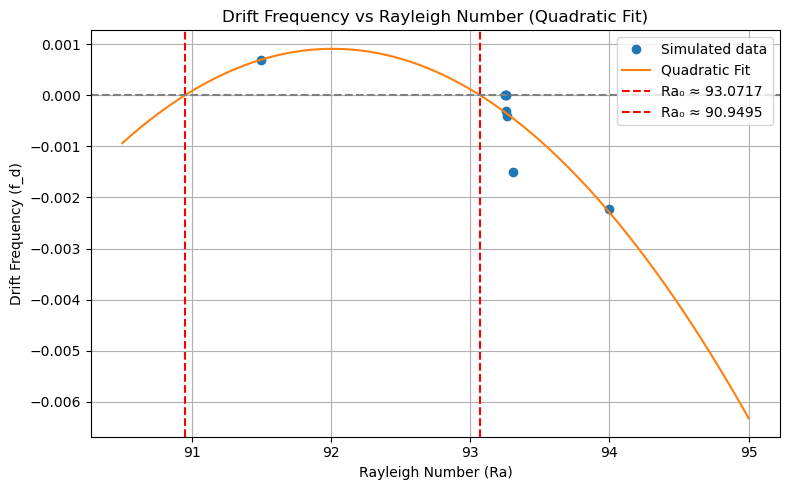


Quadratic fit coefficients: a = -0.000809, b = 0.148958, c = -6.851942
Estimated Ra where f_d = 0: [93.07172725 90.94953332]


In [27]:
#Putting everything together using 3 different simulations

#NON-LINEAR FIT

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

# Define your simulations
simulations = {
    91.5: "C:/Users/simon/OneDrive/Desktop/Ra9150/movie_test/",
    93.25: "C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/",
    93.2540: "C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/",
    93.2550: "C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/",
    93.26: "C:/Users/simon/OneDrive/Desktop/Ra932600/movie_test/",
    93.2647: "C:/Users/simon/OneDrive/Desktop/Ra9326/movie_test/",
    93.31: "C:/Users/simon/OneDrive/Desktop/Ra9331/movie_test/",
    94.0: "C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/",
}

# Choose a fixed point
target_r_frac = 0.5
target_phi = 0.0

Ra_list = []
fd_list = []

def extract_drift_frequency(folderpath, plot_preview=False):
    npz_files = sorted(glob.glob(folderpath + "test_*.npz"))
    times, T1_values, T2_values = [], [], []

    phi1 = 0.0
    phi2 = 0.2

    for fname in npz_files:
        try:
            aa = np.load(fname, allow_pickle=True)
            if "temperature" not in aa.files:
                continue

            temp = aa["temperature"]
            time = aa["time"].item()
            grid_r = aa["grid_r"]
            grid_phi = aa["grid_phi"]

            i_r = np.argmin(np.abs(grid_r - 0.5))
            i_phi1 = np.argmin(np.abs(grid_phi - phi1))
            i_phi2 = np.argmin(np.abs(grid_phi - phi2))

            T1, T2 = temp[i_r, i_phi1], temp[i_r, i_phi2]
            times.append(time)
            T1_values.append(T1)
            T2_values.append(T2)

        except Exception as e:
            print(f"Error reading {fname}: {e}")

    times = np.array(times)
    T1_values = np.array(T1_values)
    T2_values = np.array(T2_values)

    if len(times) < 10 or np.std(T1_values) < 1e-4:
        print(f"Signal too short or too flat in {folderpath}")
        return 0.0

    # Optional: smooth signal
    T1_values = uniform_filter1d(T1_values, size=5)
    T2_values = uniform_filter1d(T2_values, size=5)

    # --- Fit sine function ---
    def sine_func(t, A, f, phi, C):
        return A * np.sin(2 * np.pi * f * t + phi) + C

    guess = [np.std(T1_values), 0.004, 0, np.mean(T1_values)]
    try:
        params, _ = curve_fit(
            sine_func,
            times,
            T1_values,
            p0=guess,
            bounds=([0, 0, -2*np.pi, -np.inf], [np.inf, 0.02, 2*np.pi, np.inf])
        )
        A, f_d, phi, C = params
    except RuntimeError:
        print(f"Fit failed for {folderpath}")
        return 0.0

    # --- Determine drift direction ---
    corr = np.correlate(T2_values - np.mean(T2_values),
                        T1_values - np.mean(T1_values), mode='full')
    lag = np.argmax(corr) - (len(T1_values) - 1)
    if lag < 0:
        f_d = -f_d

    # Optional plot preview
    if plot_preview:
        plt.figure(figsize=(8, 4))
        plt.plot(times, T1_values, label="Temperature @ φ₁")
        plt.plot(times, sine_func(times, *params), '--', label=f"Sine fit (f ≈ {f_d:.5f})")
        plt.xlabel("Time")
        plt.ylabel("Temperature")
        plt.legend()
        plt.title("Sine Fit for Drift Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_d

# Loop over simulations
for Ra, path in simulations.items():
    f_d = extract_drift_frequency(path, plot_preview=True)  # set to False once you're happy
    print(f"Ra = {Ra:.4f}, Drift frequency = {f_d:.5f}")
    Ra_list.append(Ra)
    fd_list.append(f_d)

# Fit and plot
Ra_vals = np.array(Ra_list)
fd_vals = np.array(fd_list)

fd_vals[4] = fd_vals[4]*-1
fd_vals[5] = fd_vals[5]*-1
fd_vals[6] = fd_vals[6]*-1

# Fit a 2nd-degree polynomial: f_d = a*Ra^2 + b*Ra + c
poly_coeffs = np.polyfit(Ra_vals, fd_vals, deg=2)  # Returns [a, b, c]
a, b, c = poly_coeffs

# Generate fitted curve
Ra_fit = np.linspace(min(Ra_vals) - 1, max(Ra_vals) + 1, 200)
fd_fit = np.polyval(poly_coeffs, Ra_fit)

# Optionally: solve for Ra where f_d = 0 (roots of polynomial)
Ra_roots = np.roots(poly_coeffs)
Ra_zero_drift = Ra_roots[np.isreal(Ra_roots)].real  # Real part of roots

plt.figure(figsize=(8, 5))
plt.plot(Ra_vals, fd_vals, 'o', label='Simulated data')
plt.plot(Ra_fit, fd_fit, '-', label='Quadratic Fit')

for r in Ra_zero_drift:
    plt.axvline(r, color='red', linestyle='--', label=f"Ra₀ ≈ {r:.4f}")

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Drift Frequency (f_d)")
plt.title("Drift Frequency vs Rayleigh Number (Quadratic Fit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nQuadratic fit coefficients: a = {a:.6f}, b = {b:.6f}, c = {c:.6f}")
print(f"Estimated Ra where f_d = 0: {Ra_zero_drift}")

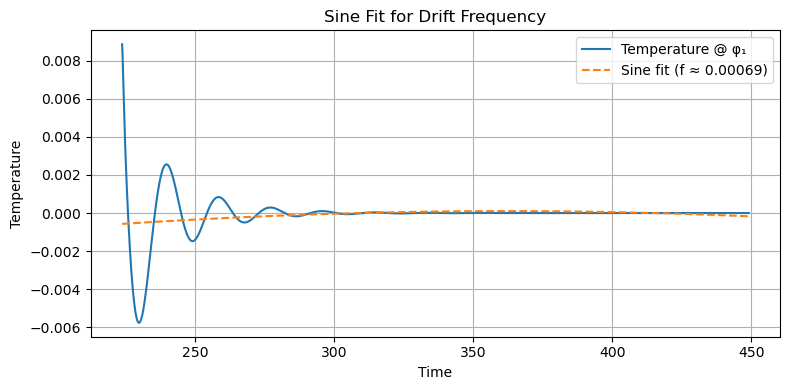

Ra = 91.5000, Drift frequency = 0.00069
Signal too short or too flat in C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/
Ra = 93.2540, Drift frequency = 0.00000


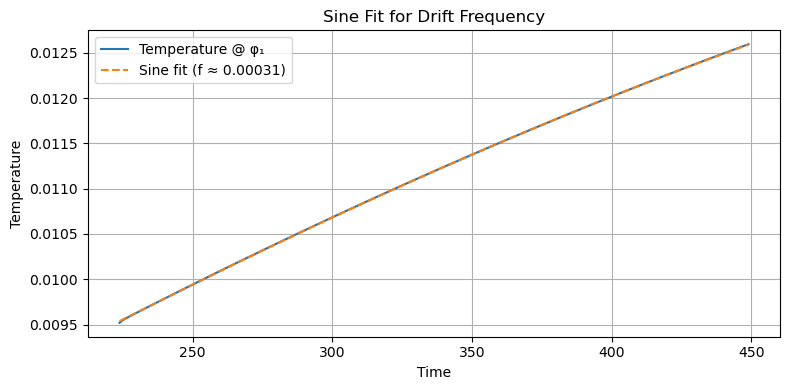

Ra = 93.2600, Drift frequency = 0.00031


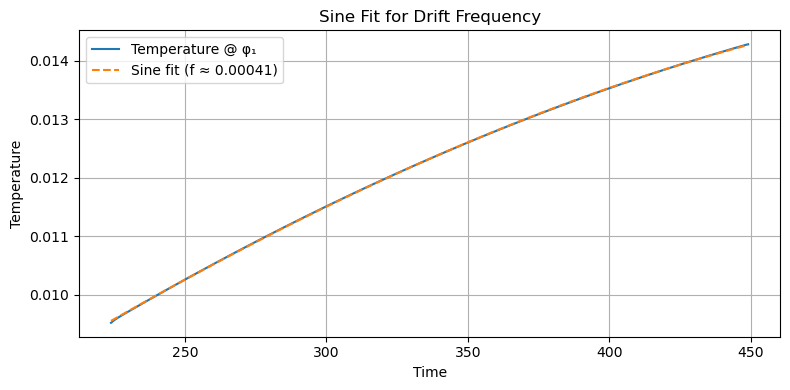

Ra = 93.2647, Drift frequency = 0.00041


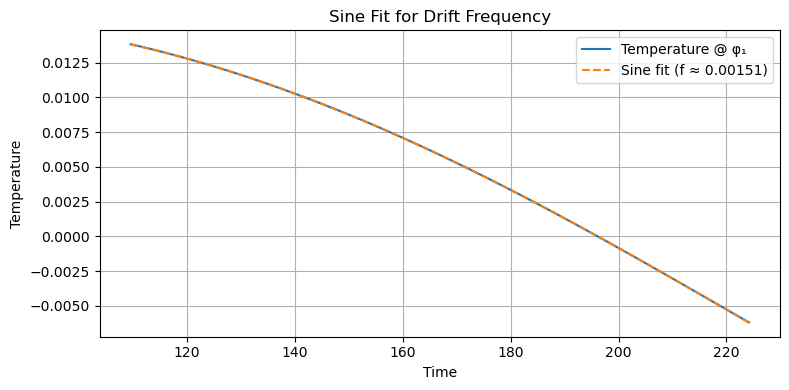

Ra = 93.3100, Drift frequency = 0.00151


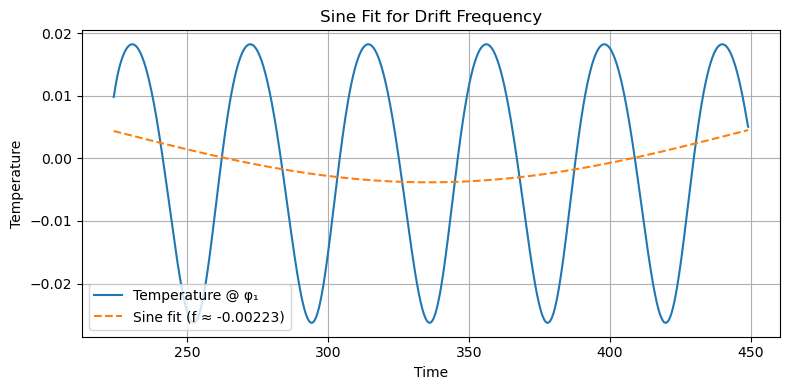

Ra = 94.0000, Drift frequency = -0.00223


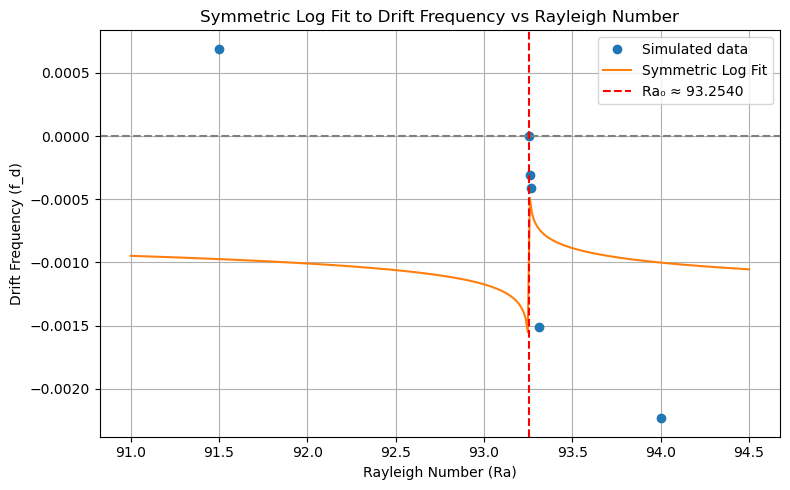


Fitted parameters:
a     ≈ -0.0001
Ra₀   ≈ 93.2540
offset b ≈ -0.0010


In [14]:
#Putting everything together using 3 different simulations

#LOG FIT

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

# Define your simulations
simulations = {
    91.5: "C:/Users/simon/OneDrive/Desktop/Ra9150/movie_test/",
    #93.25: "C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/",
    93.2540: "C:/Users/simon/OneDrive/Desktop/Ra932540/movie_test/",
    #93.2550: "C:/Users/simon/OneDrive/Desktop/Ra932550/movie_test/",
    93.26: "C:/Users/simon/OneDrive/Desktop/Ra932600/movie_test/",
    93.2647: "C:/Users/simon/OneDrive/Desktop/Ra9326/movie_test/",
    93.31: "C:/Users/simon/OneDrive/Desktop/Ra9331/movie_test/",
    94.0: "C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/",
}

# Choose a fixed point
target_r_frac = 0.5
target_phi = 0.0

Ra_list = []
fd_list = []

def extract_drift_frequency(folderpath, plot_preview=False):
    npz_files = sorted(glob.glob(folderpath + "test_*.npz"))
    times, T1_values, T2_values = [], [], []

    phi1 = 0.0
    phi2 = 0.2

    for fname in npz_files:
        try:
            aa = np.load(fname, allow_pickle=True)
            if "temperature" not in aa.files:
                continue

            temp = aa["temperature"]
            time = aa["time"].item()
            grid_r = aa["grid_r"]
            grid_phi = aa["grid_phi"]

            i_r = np.argmin(np.abs(grid_r - 0.5))
            i_phi1 = np.argmin(np.abs(grid_phi - phi1))
            i_phi2 = np.argmin(np.abs(grid_phi - phi2))

            T1, T2 = temp[i_r, i_phi1], temp[i_r, i_phi2]
            times.append(time)
            T1_values.append(T1)
            T2_values.append(T2)

        except Exception as e:
            print(f"Error reading {fname}: {e}")

    times = np.array(times)
    T1_values = np.array(T1_values)
    T2_values = np.array(T2_values)

    if len(times) < 10 or np.std(T1_values) < 1e-4:
        print(f"Signal too short or too flat in {folderpath}")
        return 0.0

    # Optional: smooth signal
    T1_values = uniform_filter1d(T1_values, size=5)
    T2_values = uniform_filter1d(T2_values, size=5)

    # --- Fit sine function ---
    def sine_func(t, A, f, phi, C):
        return A * np.sin(2 * np.pi * f * t + phi) + C

    guess = [np.std(T1_values), 0.004, 0, np.mean(T1_values)]
    try:
        params, _ = curve_fit(
            sine_func,
            times,
            T1_values,
            p0=guess,
            bounds=([0, 0, -2*np.pi, -np.inf], [np.inf, 0.02, 2*np.pi, np.inf])
        )
        A, f_d, phi, C = params
    except RuntimeError:
        print(f"Fit failed for {folderpath}")
        return 0.0

    # --- Determine drift direction ---
    corr = np.correlate(T2_values - np.mean(T2_values),
                        T1_values - np.mean(T1_values), mode='full')
    lag = np.argmax(corr) - (len(T1_values) - 1)
    if lag < 0:
        f_d = -f_d

    # Optional plot preview
    if plot_preview:
        plt.figure(figsize=(8, 4))
        plt.plot(times, T1_values, label="Temperature @ φ₁")
        plt.plot(times, sine_func(times, *params), '--', label=f"Sine fit (f ≈ {f_d:.5f})")
        plt.xlabel("Time")
        plt.ylabel("Temperature")
        plt.legend()
        plt.title("Sine Fit for Drift Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_d

# Loop over simulations
for Ra, path in simulations.items():
    f_d = extract_drift_frequency(path, plot_preview=True)  # set to False once you're happy
    print(f"Ra = {Ra:.4f}, Drift frequency = {f_d:.5f}")
    Ra_list.append(Ra)
    fd_list.append(f_d)

# Fit and plot
Ra_vals = np.array(Ra_list)
fd_vals = np.array(fd_list)

fd_vals[2] = fd_vals[2]*-1
fd_vals[3] = fd_vals[3]*-1
fd_vals[4] = fd_vals[4]*-1
#fd_vals[5] = fd_vals[5]*-1
#fd_vals[6] = fd_vals[6]*-1

def symmetric_log_model(Ra, a, Ra0, b):
    return a * np.sign(Ra - Ra0) * np.log(np.abs(Ra - Ra0) + 1e-6) + b

# Initial guess: [slope, critical Ra0, offset]
guess = [1.0, 93.25, 0.0]

# Fit full data
params, _ = curve_fit(symmetric_log_model, Ra_vals, fd_vals, p0=guess)

a_fit, Ra0_fit, b_fit = params

Ra_plot = np.linspace(min(Ra_vals)-0.5, max(Ra_vals)+0.5, 300)
fd_plot = symmetric_log_model(Ra_plot, *params)

plt.figure(figsize=(8, 5))
plt.plot(Ra_vals, fd_vals, 'o', label='Simulated data')
plt.plot(Ra_plot, fd_plot, '-', label='Symmetric Log Fit')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(Ra0_fit, color='red', linestyle='--', label=f"Ra₀ ≈ {Ra0_fit:.4f}")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Drift Frequency (f_d)")
plt.title("Symmetric Log Fit to Drift Frequency vs Rayleigh Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nFitted parameters:")
print(f"a     ≈ {a_fit:.4f}")
print(f"Ra₀   ≈ {Ra0_fit:.4f}")
print(f"offset b ≈ {b_fit:.4f}")

In [12]:
print(fd_vals)
fd_vals[1]

[ 0.00069082  0.          0.          0.00030937 -0.00041222 -0.00151046
  0.00223358]


0.0